<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/main/AssignmentsPart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
     import dlroms.fespaces as fe

In [ ]:
import numpy as np
import importlib
import dispenser
importlib.reload(dispenser)

from dispenser import FOMsolver, FOMsolverhom, Vh, Vb, compute_basis_functions

# **Assignments overview - Part 1**

This notebook contains a brief overview of three assignments related to the first part of the course.

**NB**: if you are using Colab to run this notebook, make sure to upload the scripts $\textsf{dispenser.py}$, $\textsf{playground.py}$ and $\textsf{electron.py}$ to the notebook environment ("Folder" icon on your left, near the "Key" icon). If you are working locally, instead, make sure that those scripts are in the same folder of the notebook.

## **Convection-diffusion equation**: designing a chemical dispenser

# <font color='yellow'>Task i)

In [ ]:
# Compute basis functions
b1, b2, b3 = compute_basis_functions()
dispenser.b1 = b1  # Make b1, b2, b3 available in dispenser.py
dispenser.b2 = b2
dispenser.b3 = b3

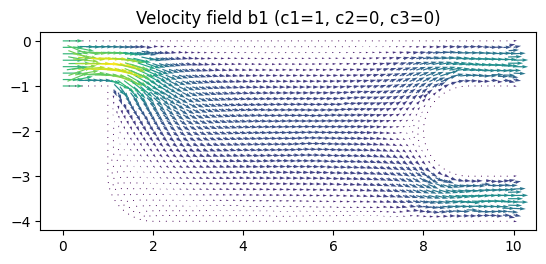

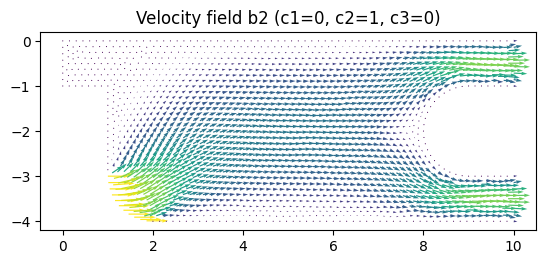

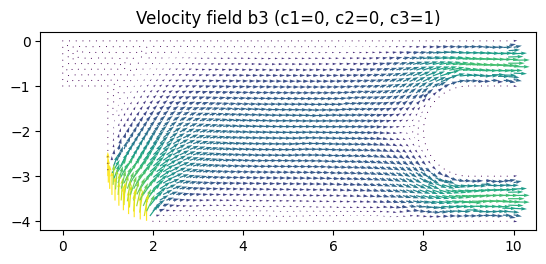

In [ ]:
import matplotlib.pyplot as plt
from fenics import plot

# Convert to FEniCS Function for plotting
bf1 = fe.asfunction(b1, Vb)
bf2 = fe.asfunction(b2, Vb)
bf3 = fe.asfunction(b3, Vb)

# Plot b1
plt.figure()
plot(bf1, title="Velocity field b1 (c1=1, c2=0, c3=0)")
plt.show()

# Plot b2
plt.figure()
plot(bf2, title="Velocity field b2 (c1=0, c2=1, c3=0)")
plt.show()

# Plot b3
plt.figure()
plot(bf3, title="Velocity field b3 (c1=0, c2=0, c3=1)")
plt.show()


In [ ]:
c0= np.array([40, 20, 30])
u = FOMsolver(*c0)
u.shape


(701, 1940)

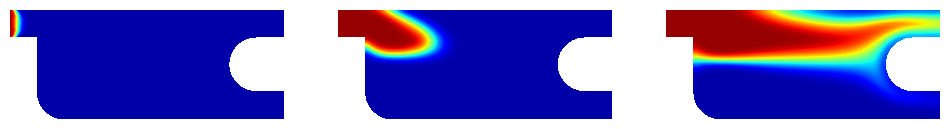

In [ ]:
fe.multiplot(u[[10, 200, 700]], (1, 3), Vh, vmin=u.min(), vmax=u.max())

In [ ]:
uhom, *_ =FOMsolverhom(*c0)
uhom.shape

(701, 1940)

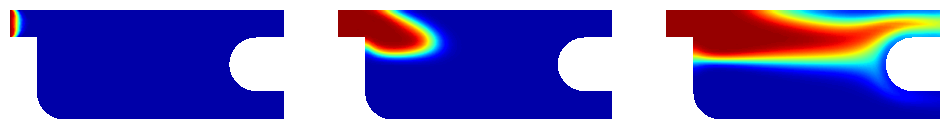

In [ ]:
fe.multiplot(uhom[[10, 200, 700]], (1, 3), Vh, vmin=uhom.min(), vmax=uhom.max())

In [ ]:
# Verify that u = uₕₒₘ + 1
error = np.max(np.abs(u - (uhom + 1)))
print(f"Maximum error between u and uₕₒₘ + 1: {error}")

Maximum error between u and uₕₒₘ + 1: 0.007160849108436257


In [ ]:
#fe.animate(u[::10], Vh)

In [ ]:
#fe.animate(u_hom[::10], Vh)

In [ ]:
from dispenser import bottomOutflow

print(bottomOutflow(u))
print(bottomOutflow(uhom))

0.022940463063366293
-0.9769096209274295


# <font color='yellow'>Task ii)

In [ ]:
np.random.seed(0)

nsim = 20
cList = []
uhomList = []

for j in range(nsim):
  cj = 50 * np.random.rand(3)
  uhomj, u0j = FOMsolverhom(*cj)

  cList.append(cj)
  uhomList.append(uhomj)


In [ ]:
c = np.stack(cList)
uhom = np.stack(uhomList)
c.shape

(20, 3)

In [ ]:
uhom.shape # snapshots matrix: Nh x Nsamples

(20, 701, 1940)

In [ ]:
ntrain = nsim // 2
Utrain = uhom[:ntrain].reshape(-1, Vh.dim()).T
Utrain.shape

(1940, 7010)

In [ ]:
from scipy.linalg import svd
X, s, Yt = svd(Utrain, full_matrices = False)


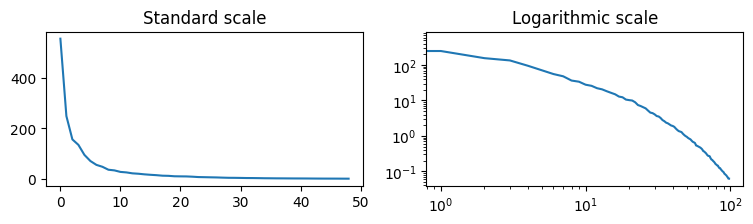

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.plot(s[1:50])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.loglog(s[1:100])
plt.title("Logarithmic scale")
plt.show()

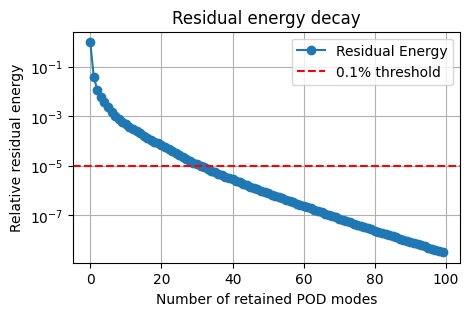

In [ ]:
import matplotlib.pyplot as plt

# Total energy (sum of all singular values squared)
total_energy = np.sum(s**2)

# Residual energy for each number of modes
residual_energy = np.cumsum(s[::-1]**2)[::-1] / total_energy

# Plot residual energy decay
plt.figure(figsize=(5, 3))
plt.plot(residual_energy[:100], 'o-', label='Residual Energy')
plt.xlabel("Number of retained POD modes")
plt.ylabel("Relative residual energy")
plt.title("Residual energy decay")
plt.grid(True)
plt.yscale("log")
plt.axhline(1e-5, color='red', linestyle='--', label='0.1% threshold')
plt.legend()
plt.show()


In [ ]:
# Desired energy retention level (e.g., 99.9% retained, 0.1% lost)
tolerance = 1e-5

# Compute total energy and residual energy as before
total_energy = np.sum(s**2)
residual_energy = np.cumsum(s[::-1]**2)[::-1] / total_energy

# Find smallest n such that residual energy is below tolerance
n_opt = np.argmax(residual_energy <= tolerance)

print(f"Selected number of POD modes (n): {n_opt}")
print(f"Corresponding residual energy: {residual_energy[n_opt]:.2e}")

# You can now define V using this n_opt
V = X[:, :n_opt]


Selected number of POD modes (n): 32
Corresponding residual energy: 8.56e-06


<font color='Orange'> Residual energy tells you how much information (energy) is not captured by your reduced basis (POD modes). It is a measure of the loss in the reduced approximation.

In [ ]:
n =32
V = X[:, :n]

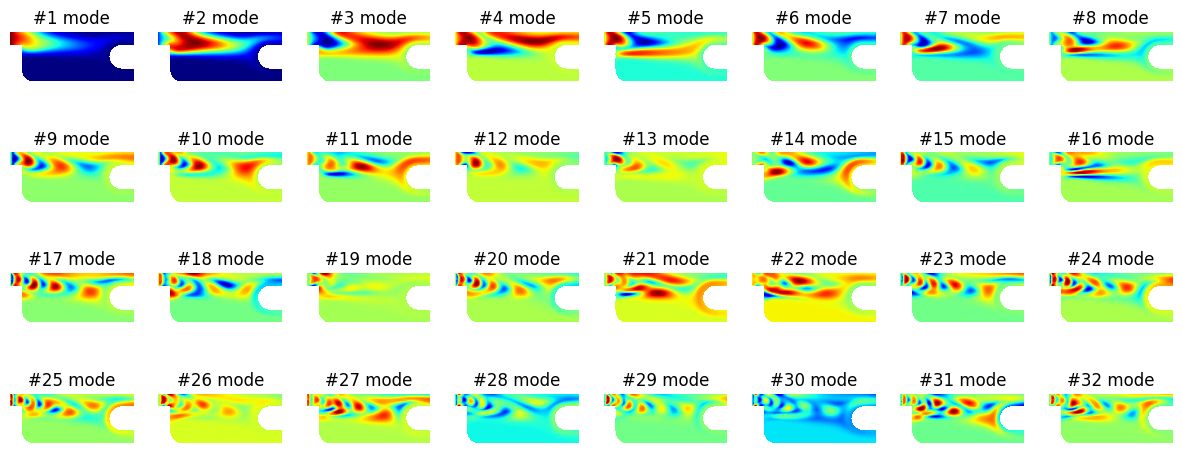

In [ ]:
plt.figure(figsize = (15, 6))
for k in range(n):
  plt.subplot(4, n//4, k+1)
  fe.plot(V[:, k], Vh)
  plt.title("#%d mode" % (k+1))
plt.show()

In [ ]:
from dlroms import num2p
Utest = uhom[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest) #offline projection error
#It measures how well a fixed reduced basis approximates your FOM snapshots.

errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

ntest = uhom.shape[0] - ntrain
errors = errors.reshape(ntest, uhom.shape[1])

print("Average projection error: %s." % num2p(errors.max(axis = 1).mean()))

Average projection error: 1.88%.


# <font color='yellow'>Task iii)

In [ ]:
from dispenser import assemble_FOM_matrices

M, S, B1, B2, B3 = assemble_FOM_matrices()

Mrb  = V.T @ M  @ V
Srb  = V.T @ S  @ V
B1rb = V.T @ B1 @ V
B2rb = V.T @ B2 @ V
B3rb = V.T @ B3 @ V


In [ ]:
def RBstep(cn, dt, mu):
    c1, c2, c3 = mu
    Arb = Mrb + dt * Srb + dt * (c1 * B1rb + c2 * B2rb + c3 * B3rb)
    Frb = Mrb @ cn
    return np.linalg.solve(Arb, Frb)

In [ ]:
u0 = u0j
u0.shape

(1940,)

In [ ]:
def RBsolver(mu, dt=5e-4, steps=700):
    c0 = V.T @ u0  # Project initial condition to reduced space
    c = [c0]

    for _ in range(steps):
        c.append(RBstep(c[-1], dt, mu))

    c = np.stack(c)
    u = c @ V.T # lifting to FOM
    u[0] = u0  # Set initial condition back in full space
    return u

In [ ]:
mu0 = np.array([40, 20, 30])
uFOM = FOMsolverhom(*mu0)
uRB = RBsolver(mu0)

Average amount of chemical that has exited the domain (FOM): -0.97691
Average amount of chemical that has exited the domain (RB):  -0.97899


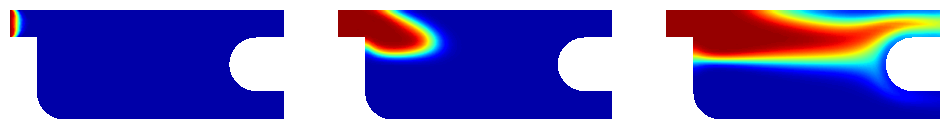

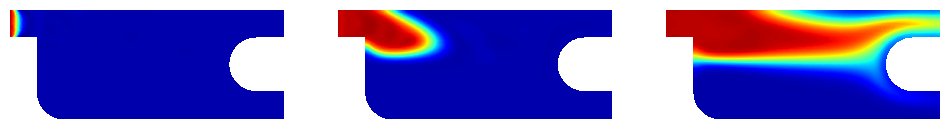

In [ ]:
#fe.multiplot(uRB[[10, 200, 700]], (1, 3),Vh)
fe.multiplot(uFOM[0][[10, 200, 700]], (1, 3), Vh, vmin=uFOM[0].min(), vmax=uFOM[0].max())
fe.multiplot(uRB[[10, 200, 700]],  (1, 3),Vh, vmin=uRB.min(), vmax=uRB.max())

j_fom = bottomOutflow(uFOM[0])
print(f"Average amount of chemical that has exited the domain (FOM): {j_fom:.5f}")

j_rb = bottomOutflow(uRB)
print(f"Average amount of chemical that has exited the domain (RB):  {j_rb:.5f}")


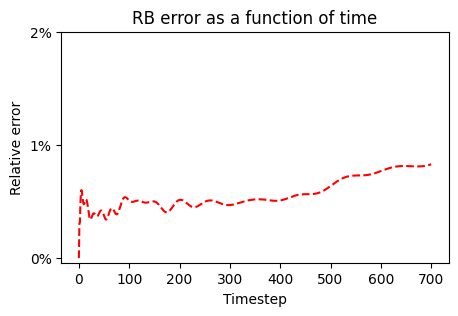

In [ ]:
errors = np.linalg.norm(uFOM[0] - uRB, axis=1) / np.linalg.norm(uFOM[0], axis=1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.01, 0.02], ["0%", "1%", "2%"])
plt.show()

In [ ]:
from time import perf_counter
t0 = perf_counter()
FOMsolverhom(*mu0)
t1 = perf_counter()
dtFOM = t1 - t0
print("FOM evaluation time: %.2f milliseconds." % (1000*dtFOM))

t0 = perf_counter()
RBsolver(mu0)
t1 = perf_counter()
dtROM = t1 - t0
print("ROM evaluation time: %.2f milliseconds." % (1000*dtROM))
print("\n>> Boost: x%d." % (dtFOM//dtROM))

FOM evaluation time: 13512.72 milliseconds.
ROM evaluation time: 59.59 milliseconds.

>> Boost: x226.


In [ ]:
Utest = uhom[ntrain:]
URBtest = [RBsolver(m) for m in c[ntrain:]]

URBtest = np.stack(URBtest)
errors = np.linalg.norm(Utest-URBtest, axis = -1)/np.linalg.norm(Utest, axis = -1)
etest = errors.max(axis = -1).mean()

print("Average uniform relative error: %s." % num2p(etest))

Average uniform relative error: 2.04%.


In [ ]:
from time import time
from matplotlib import pyplot as plt

# Store time-resolved errors
timewise_errors_all = []
rel_errors_timewise = []
times_fom = []
times_rb = []
J_errors = []

# Use 10 test samples from your dataset
mu_test = c[ntrain:]

for j, mu in enumerate(mu_test):
    # FOM
    t0 = time()
    u_fom, u0j = FOMsolverhom(*mu, steps=700, dt=5e-4)
    times_fom.append(time() - t0)
    J_fom = bottomOutflow(u_fom)

    # RB
    u0 = u0j
    t0 = time()
    u_rb = RBsolver(mu, dt=5e-4, steps=700)
    times_rb.append(time() - t0)
    J_rb = bottomOutflow(u_rb)

    # Compute relative error per timestep
    rel_error_t = np.linalg.norm(u_fom - u_rb, axis=1) / np.linalg.norm(u_fom, axis=1)
    timewise_errors_all.append(rel_error_t)
    rel_errors_timewise.append(np.mean(rel_error_t))  # avg error per simulation

    # Relative error in functional
    err_J = abs(J_fom - J_rb) / abs(J_fom)
    J_errors.append(err_J)

# Convert to array
timewise_errors_all = np.array(timewise_errors_all)


In [ ]:
import numpy as np

print(f"\nAverage FOM time: {np.mean(times_fom):.3f} s")
print(f"Average RB time: {np.mean(times_rb):.3f} s")
print(f"Average Speedup factor: {np.mean(times_fom) / np.mean(times_rb):.1f}x")



Average FOM time: 13.121 s
Average RB time: 0.031 s
Average Speedup factor: 420.0x


In [ ]:
rel_errors_timewise = np.array(rel_errors_timewise)
print(f"\nAverage relative error over the test set: {np.mean(rel_errors_timewise):.3%}")
print(f"Max relative error across simulations: {np.max(rel_errors_timewise):.3%}")
print(f"Standard deviation of relative errors: {np.std(rel_errors_timewise):.3%}")



Average relative error over the test set: 0.967%
Max relative error across simulations: 4.388%
Standard deviation of relative errors: 1.168%


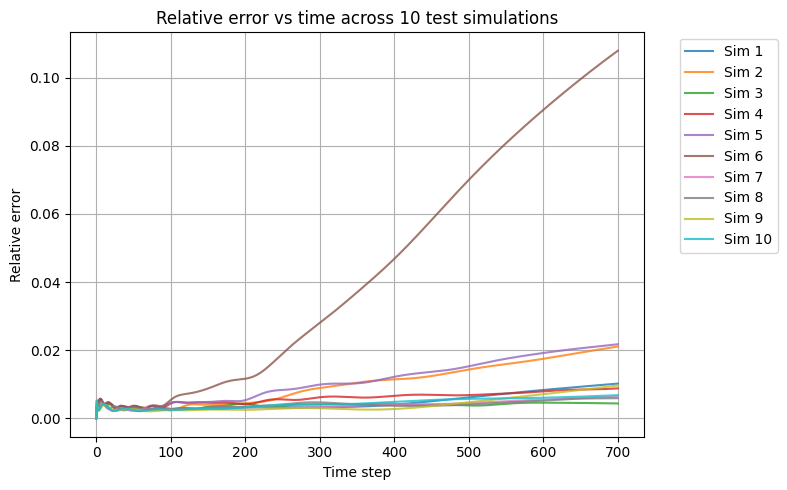

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for j in range(len(mu_test)):  # or simply: range(10)
    plt.plot(timewise_errors_all[j], label=f"Sim {j+1}", alpha=0.8)

plt.xlabel("Time step")
plt.ylabel("Relative error")
plt.title("Relative error vs time across 10 test simulations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True)
plt.tight_layout()
plt.show()


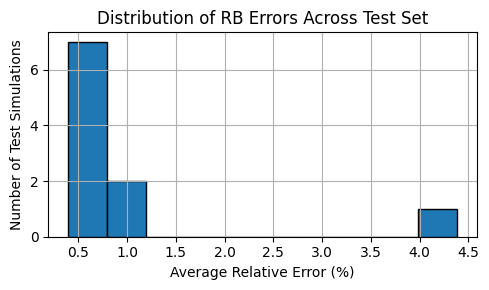

In [ ]:
plt.figure(figsize=(5,3))
plt.hist(rel_errors_timewise * 100, bins=10, edgecolor='k')
plt.xlabel("Average Relative Error (%)")
plt.ylabel("Number of Test Simulations")
plt.title("Distribution of RB Errors Across Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Average relative error in J:", np.mean(J_errors))
print("Max relative error in J:", np.max(J_errors))

Average relative error in J: 0.007932766198154783
Max relative error in J: 0.05730988764342156


# <font color='yellow'>Task vi)

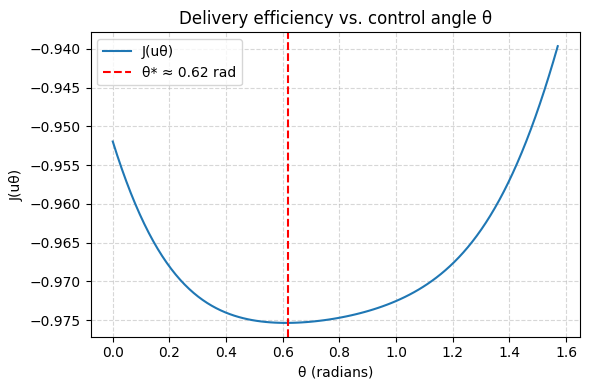

Optimal θ* ≈ 0.6188 radians ≈ 35.45 degrees
Minimum J(uθ) ≈ -0.975364


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dispenser import bottomOutflow

# Define parameters
c1 = 50
theta_vals = np.linspace(0, np.pi / 2, 100)
J_vals = []

# Loop over θ values
for theta in theta_vals:
    c2 = 50*np.cos(theta)
    c3 = 50*np.sin(theta)
    mu = [c1, c2, c3]

    u_theta = RBsolver(mu, dt=5e-4, steps=700)  # same dt and steps as FOM
    J_val = bottomOutflow(u_theta)
    J_vals.append(J_val)

# Find the optimal theta
theta_star_index = np.argmin(J_vals)
theta_star = theta_vals[theta_star_index]
J_min = J_vals[theta_star_index]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(theta_vals, J_vals, label='J(uθ)')
plt.axvline(theta_star, color='r', linestyle='--', label=f'θ* ≈ {theta_star:.2f} rad')
plt.xlabel("θ (radians)")
plt.ylabel("J(uθ)")
plt.title("Delivery efficiency vs. control angle θ")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Optimal θ* ≈ {theta_star:.4f} radians ≈ {np.degrees(theta_star):.2f} degrees")
print(f"Minimum J(uθ) ≈ {J_min:.6f}")